# Analysis of Customer Transactions

In [1]:
import io
import os
import requests
import zipfile

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

from fin_crime.data_processor import DataProcessor

In [2]:
idx = pd.IndexSlice

pd.options.display.max_columns = 100
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Defines

In [3]:
input_data_dir = os.path.join("data", "processed")
cur_file_path = os.path.join(input_data_dir, "tr_fincrime_train.parquet")

cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)

In [4]:
url = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip'
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall(os.path.join(cache_dir, 'states_shp'))

# Data

## Loading

In [5]:
df = pd.read_parquet(cur_file_path)

In [6]:
df_usa = gpd.read_file(os.path.join(cache_dir, 'states_shp/cb_2018_us_state_500k.shp'))

## Transformations

In [7]:
# Sorting on credit card number and transaction timestamp
df = df.sort_values(by=["cc_num", "trans_date_trans_time"], ignore_index=True)

In [8]:
df["distance"] = np.linalg.norm(
    df[["lat", "long"]].values - df[["merch_lat", "merch_long"]].values,
    ord=2,
    axis=1
)

In [9]:
df["age_at_transaction"] = (df["trans_date_trans_time"] - df["dob"]) / pd.Timedelta("365d")

In [10]:
df["trans_hour"] = df["trans_date_trans_time"].dt.hour

In [11]:
dfg_card = gpd.GeoDataFrame(
    df[['trans_num', 'long', 'lat']],
    geometry=gpd.points_from_xy(df['long'], df['lat']), 
    crs="EPSG:4269"
)

dfg_merch = gpd.GeoDataFrame(
    df[['trans_num', 'merch_long', 'merch_lat']],
    geometry=gpd.points_from_xy(df['merch_long'], df['merch_lat']), 
    crs="EPSG:4269"
)

In [12]:
df["card_state"] = gpd.sjoin(dfg_card, df_usa[['STUSPS', 'geometry']], how='left')["STUSPS"]
df["merchant_state"] = gpd.sjoin(dfg_merch, df_usa[['STUSPS', 'geometry']], how='left')["STUSPS"]
df["merchant_state"] = df["merchant_state"].fillna("NaN")

In [13]:
# How many past fraud cases were there on this card before the current transaction
df["is_fraud_cumsum"] = df.groupby("cc_num")["is_fraud"].transform("cumsum") - df["is_fraud"]
df["trans_wait_time"] = df.groupby('cc_num')['trans_date_trans_time'].transform('diff') / pd.Timedelta("1d")
df["fraud_wait_time"] = df.groupby(['cc_num', 'is_fraud_cumsum'])['trans_wait_time'].transform("cumsum")

# Data Familiarisation

## Raw Data

- No missing values
- Sensible value types

In [14]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance,age_at_transaction,trans_hour,card_state,merchant_state,is_fraud_cumsum,trans_wait_time,fraud_wait_time
0,2019-01-01 12:47:15,60416207185,"fraud_Jones, Sawayn and Romaguera",misc_net,7.27000,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00480,-108.89640,1645,Information systems manager,1986-02-17,98e3dcf98101146a577f85a34e58feec,1325422035,43.97471,-109.74190,0,1.28670,32.89461,12,WY,WY,0,NaN,NaN
1,2019-01-02 08:44:57,60416207185,fraud_Berge LLC,gas_transport,52.94000,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00480,-108.89640,1645,Information systems manager,1986-02-17,498120fc45d277f7c88e3dba79c33865,1325493897,42.01877,-109.04417,0,0.99705,32.89689,8,WY,WY,0,0.83174,0.83174
2,2019-01-02 08:47:36,60416207185,fraud_Luettgen PLC,gas_transport,82.08000,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00480,-108.89640,1645,Information systems manager,1986-02-17,95f514bb993151347c7acdf8505c3d62,1325494056,42.96133,-109.15756,0,0.26476,32.89689,8,WY,WY,0,0.00184,0.83358
3,2019-01-02 12:38:14,60416207185,fraud_Daugherty LLC,kids_pets,34.79000,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00480,-108.89640,1645,Information systems manager,1986-02-17,4f0c1a14e0aa7eb56a490780ef9268c5,1325507894,42.22823,-108.74768,0,0.79068,32.89733,12,WY,WY,0,0.16016,0.99374
4,2019-01-02 13:10:46,60416207185,fraud_Beier and Sons,home,27.18000,Mary,Diaz,F,9886 Anita Drive,Fort Washakie,WY,82514,43.00480,-108.89640,1645,Information systems manager,1986-02-17,3b2ebd3af508afba959640893e1e82bc,1325509846,43.32174,-108.09114,0,0.86539,32.89739,13,WY,WY,0,0.02259,1.01633


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 30 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   first                  1296675 non-null  object        
 6   last                   1296675 non-null  object        
 7   gender                 1296675 non-null  object        
 8   street                 1296675 non-null  object        
 9   city                   1296675 non-null  object        
 10  state                  1296675 non-null  object        
 11  zip                    1296675 non-null  int64         
 12  lat                    12966

## Date Ranges

- No obvious outliers in `dob` field

In [16]:
df[DataProcessor.date_cols].describe()

,trans_date_trans_time,dob
count,1296675,1296675
mean,2019-10-03 12:47:28.070214912,1973-10-03 19:02:55.017178560
min,2019-01-01 00:00:18,1924-10-30 00:00:00
25%,2019-06-03 19:12:22.500000,1962-08-13 00:00:00
50%,2019-10-03 07:35:47,1975-11-30 00:00:00
75%,2020-01-28 15:02:55.500000,1987-02-22 00:00:00
max,2020-06-21 12:13:37,2005-01-29 00:00:00


## Individuals

983 cards and 693 merchants

In [17]:
df[["cc_num", "merchant"]].nunique()

cc_num      983
merchant    693
dtype: int64

No individual has more than 1 credit card

In [18]:
df.groupby(["first", "last", "gender", "street", "zip"])["cc_num"].nunique().max()

1

## Location

- Card holders are based in the US
- Over half of all transactions came from holders residing in 15 states
- 10% of transactions happened to merchants outside of the US

In [19]:
df_plot = df.groupby("state").size().sort_values(ascending=False).to_frame("Count")
df_plot["Percentage"] = df_plot["Count"] / df_plot["Count"].sum()
df_plot.head(15)

,Count,Percentage
state,,
TX,94876,0.07317
NY,83501,0.06440
PA,79847,0.06158
CA,56360,0.04347
OH,46480,0.03585
MI,46154,0.03559
IL,43252,0.03336
FL,42671,0.03291
AL,40989,0.03161


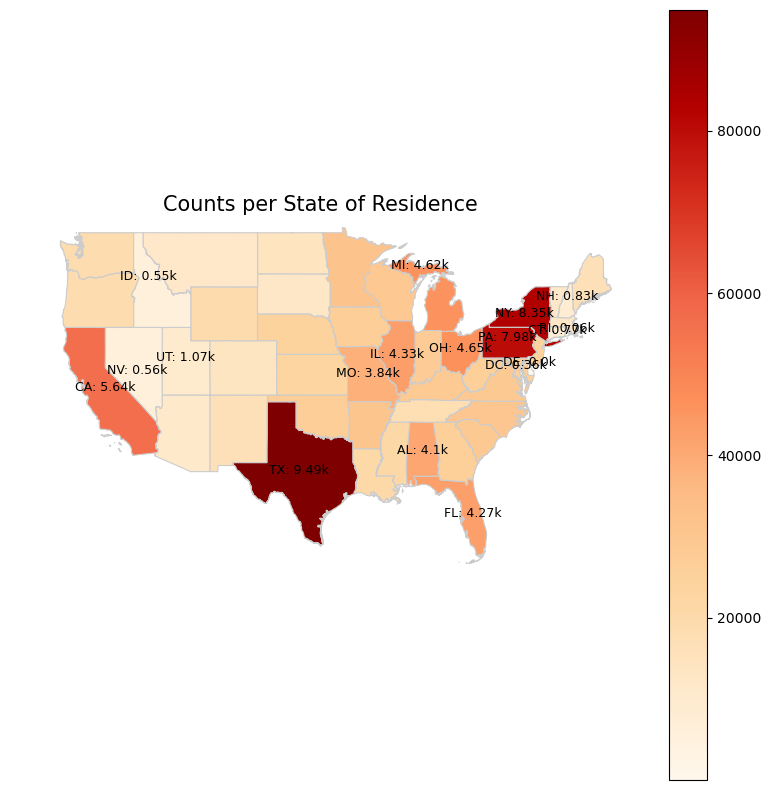

In [20]:
merged = df_usa.merge(df_plot, left_on="STUSPS", right_index=True)
merged = merged.sort_values(by='Count', ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(
    column='Count',
    cmap='OrRd',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True
)
# Remove axis off
ax.axis('off')
ax.set_xlim([-130, -65])  
ax.set_ylim([24, 50])

# Add a title
ax.set_title('Counts per State of Residence', fontdict={'fontsize': '15', 'fontweight' : '3'})

merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]
for _, row in merged.head(10).iterrows():
    plt.annotate(
        text=f"{row['STUSPS']}: {round(row['Count']/10_000, 2) }k", 
        xy=row['coords'],
        horizontalalignment='center', 
        fontsize=9
    )

for _, row in merged.tail(10).iterrows():
    plt.annotate(
        text=f"{row['STUSPS']}: {round(row['Count']/10_000, 2) }k", 
        xy=row['coords'],
        horizontalalignment='center', 
        fontsize=9
    )

plt.show()

In [21]:
(df['merchant_state'] == 'NaN').mean()

0.10015693986542502

# Fraud Stats

## What is a Fraud Odd

How much more likely is a transaction to be fraudulent vs the population baseline - i.e. ${\displaystyle \frac{P(\text{fraud} | \text{Transaction Attribute}=x )}{P(\text{fraud} )}}$

## Overview
- The dataset is highly imbalanced: 0.5% (or 7506 out of 1296675) - are fraudulent

In [22]:
df["is_fraud"].describe(), df["is_fraud"].sum()

(count   1296675.00000
 mean          0.00579
 std           0.07586
 min           0.00000
 25%           0.00000
 50%           0.00000
 75%           0.00000
 max           1.00000
 Name: is_fraud, dtype: float64,
 7506)

## Fraud Persistence
- Cases of fraud do not happen at a constant rate.
- Some individuals have reported multiple cases of fraud

<Axes: xlabel='Number of Transactions', ylabel='Number of Fraudulent Transactions'>

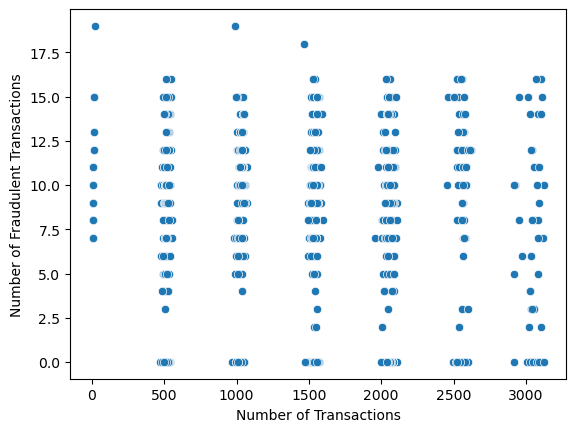

In [23]:
df_plot = df.groupby('cc_num')['is_fraud'].agg(['count', 'sum'])

df_plot = df_plot.rename(columns={
    "count": "Number of Transactions", 
    "sum": "Number of Fraudulent Transactions"
})

sns.scatterplot(
    df_plot,
    x='Number of Transactions',
    y='Number of Fraudulent Transactions'
)

- On average, individuals who suffered fraud once before are twice more likely to suffer fraud again (vs. pop. average)
- Relative fraud odds go down as the client experienced more fraudulent transactions - this is as expected given the waiting times until fraud cases (see the next slide)

In [24]:
# The odds of experiencing fraud increase if you've experienced it once
df.loc[
    df["is_fraud_cumsum"] > 0, 
    "is_fraud"
].mean() / df.loc[
    df["is_fraud_cumsum"] >= 0, 
    "is_fraud"
].mean()

2.2716937301285034

In [25]:
def _make_fraud_count_summary(x):
    df_out = df.loc[
        df["is_fraud_cumsum"] >= x, 
        "is_fraud"
    ].agg(
        ["mean", "count"]
    ).to_frame().T.reset_index(
        drop=True
    )
    df_out.insert(2, "Previous Fraud Cases", [x])

    return df_out

Text(0.5, 1.0, 'Future Fraud Odds by Number of Past Fraud Cases')

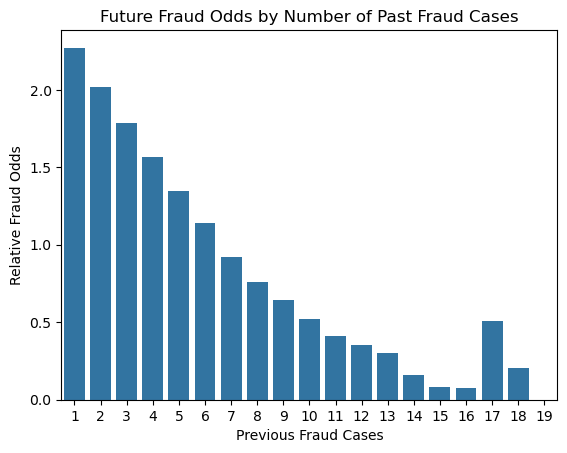

In [26]:
df_plot = pd.concat(
    [
        _make_fraud_count_summary(x)
        for x in range(0, 20)
    ],
    ignore_index=True
)
df_plot["mean"] = df_plot["mean"] / df_plot.loc[df_plot["Previous Fraud Cases"] == 0, "mean"].values[0]

df_plot.rename(columns={"mean": "Relative Fraud Odds"}, inplace=True)

sns.barplot(
    data=df_plot[df_plot["Previous Fraud Cases"] > 0],
    x='Previous Fraud Cases',
    y='Relative Fraud Odds',
)
plt.title('Future Fraud Odds by Number of Past Fraud Cases')

## Fraud Timing

- Waiting times until next fraud shorten considerably after the 1st case, then increase exponentially
- This is a mirror image of the previous finding - they are one and the same

In [27]:
df_plot = df.groupby(['cc_num', 'is_fraud_cumsum'])['fraud_wait_time'].max().to_frame().groupby(
    'is_fraud_cumsum'
)['fraud_wait_time'].agg(['mean', 'count']).reset_index()

df_plot = df_plot.rename(
    columns={
        "mean": "Avg. Time till next Fraud (days)",
        "is_fraud_cumsum": "Previous Fraud Cases"
    }
)

Text(0.5, 1.0, 'Average waiting times until the Future Fraud by Number of Past Fraud Cases')

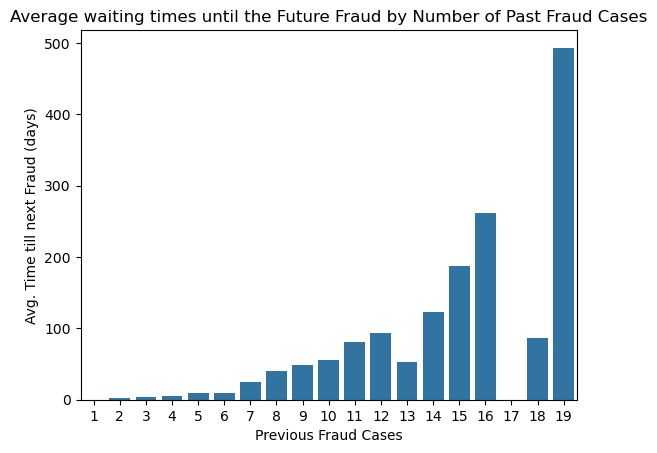

In [28]:
sns.barplot(
    data=df_plot.loc[df_plot["Previous Fraud Cases"] > 0],
    x="Previous Fraud Cases",
    y="Avg. Time till next Fraud (days)"
)
plt.title('Average waiting times until the Future Fraud by Number of Past Fraud Cases')

## Transaction amounts
- Fraudulent transactions tend to have higher transaction amounts on average, but they were not the largest outright
- Half of all fraudulent transactions were $\approx$$400 or above; most transactions at this level are normal though

In [29]:
df.groupby("is_fraud")["amt"].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,1289169.00000,67.66711,154.00797,1.00000,9.61000,47.28000,82.54000,28948.90000
1,7506.00000,531.32009,390.56007,1.06000,245.66250,396.50500,900.87500,1376.04000


Text(0.5, 1.0, 'Transaction Proportions by Amount: Fraud vs Non-Fraud \n Percentages for Each Group')

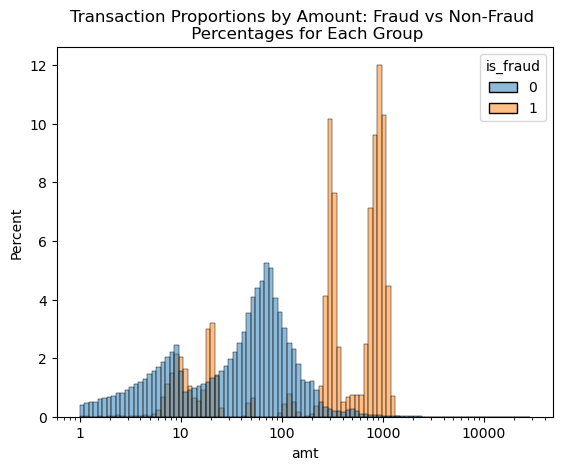

In [30]:
sns.histplot(
    data=df,
    x="amt",
    hue="is_fraud", 
    stat="percent",
    log_scale=(True, False),
    common_norm=False,
    fill=True,
    bins=100
)

plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=10.0))

plt.title('Transaction Proportions by Amount: Fraud vs Non-Fraud \n Percentages for Each Group')

Text(0.5, 1.0, 'Transactions over $400 by Amount: Fraud vs Non-Fraud \n Percentages for All Data')

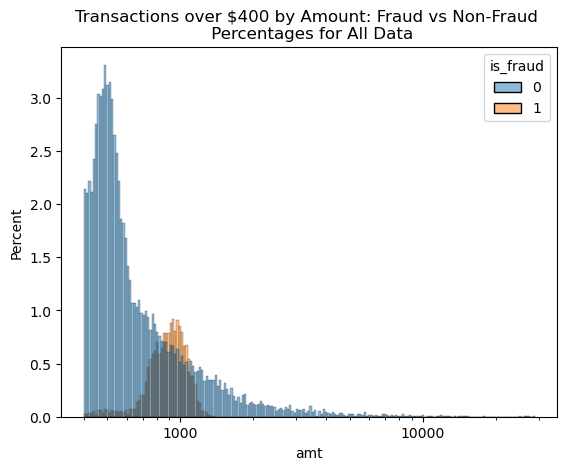

In [31]:
sns.histplot(
    data=df.loc[df["amt"] > 400],
    x="amt",
    hue="is_fraud", 
    stat="percent",
    log_scale=(True, False),
    common_norm=True,
    fill=True,
    bins=200
)

plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=10.0))

plt.title('Transactions over $400 by Amount: Fraud vs Non-Fraud \n Percentages for All Data')

## Time of Day

- Fraudulent transactions are more prevalent during the late hours between 22:00 and 03:00.

<Axes: xlabel='Hour', ylabel='Relative Fraud Odds'>

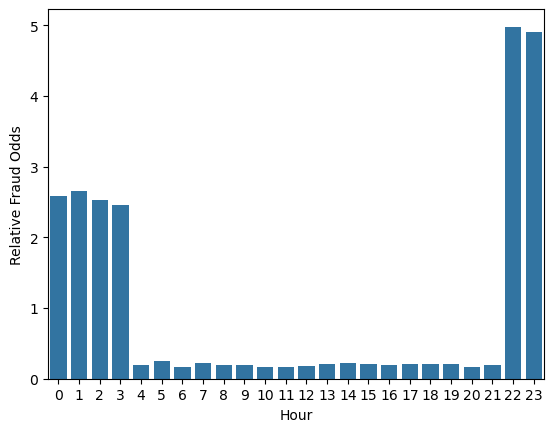

In [32]:
# df_plot = df.groupby(["trans_hour", "category"])["is_fraud"].mean().to_frame("prop") / df["is_fraud"].mean()
df_plot = df.groupby(["trans_hour"])["is_fraud"].mean().to_frame("odds") / df["is_fraud"].mean()
df_plot = df_plot.reset_index()
df_plot = df_plot.rename(columns={
    "trans_hour": "Hour",
    "odds": "Relative Fraud Odds"
})

sns.barplot(
    data=df_plot,
    x='Hour',
    y='Relative Fraud Odds',
)

## Merchant Category

- Internet shopping and internet misc have the highest relative odds (at least 2.5 more likely)
- PoS grocery also have higher odds

### Total Counts

<Axes: xlabel='Merchant Category', ylabel='Counts'>

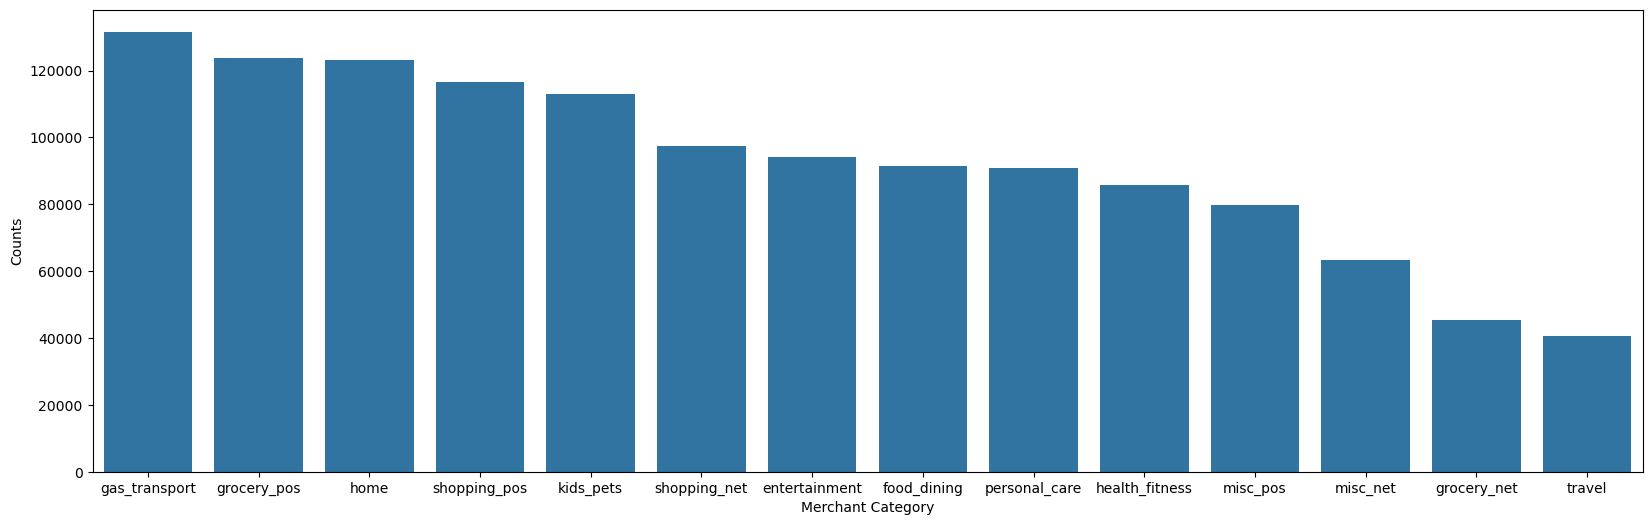

In [33]:
df_plot = df["category"].value_counts(dropna=False).to_frame("Counts")
df_plot = df_plot.reset_index()
df_plot = df_plot.rename(columns={"category": "Merchant Category"})

plt.figure(figsize=(20, 6))

sns.barplot(
    data=df_plot.reset_index(),
    x='Merchant Category',
    y='Counts',
)

### Fraud Odds vs Population Baseline

How much more likely is a transaction to be fraudulent vs the population baseline - i.e. ${\displaystyle \frac{P(\text{fraud} | \text{Merchant Category}=x )}{P(\text{fraud} )}}$

In [34]:
df_plot = df.groupby("category")["is_fraud"].mean().sort_values(ascending=False).to_frame("Fraud Odds") / df["is_fraud"].mean()
df_plot = df_plot.reset_index()
df_plot = df_plot.rename(columns={"category": "Merchant Category"})

In [35]:
df_plot

,Merchant Category,Fraud Odds
0,shopping_net,3.03378
1,misc_net,2.49764
2,grocery_pos,2.43539
3,shopping_pos,1.24820
4,gas_transport,0.81089
5,misc_pos,0.54219
6,grocery_net,0.50930
7,travel,0.49471
8,entertainment,0.42814
9,personal_care,0.41876


<Axes: xlabel='Merchant Category', ylabel='Fraud Odds'>

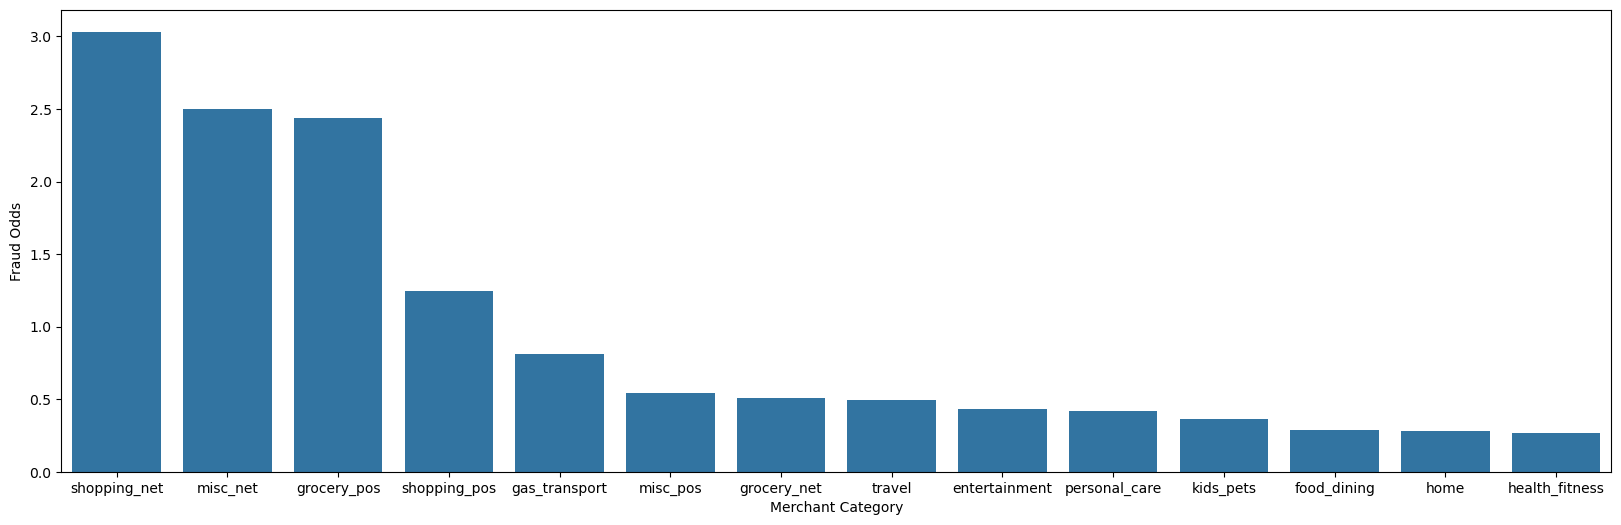

In [36]:
plt.figure(figsize=(20, 6))

sns.barplot(
    data=df_plot.reset_index(),
    x='Merchant Category',
    y='Fraud Odds',
)

## Merchant

- Almost every merchant in the dataset had at least 1 fraudulent transaction reported against them
- 28% of merchants had above average odds of fraud
- Some merchants had repeated cases of fraud from specific states / coordinates
- Distance between the card and the merchant alone does not help to distinguish between fraud and non-fraud cases

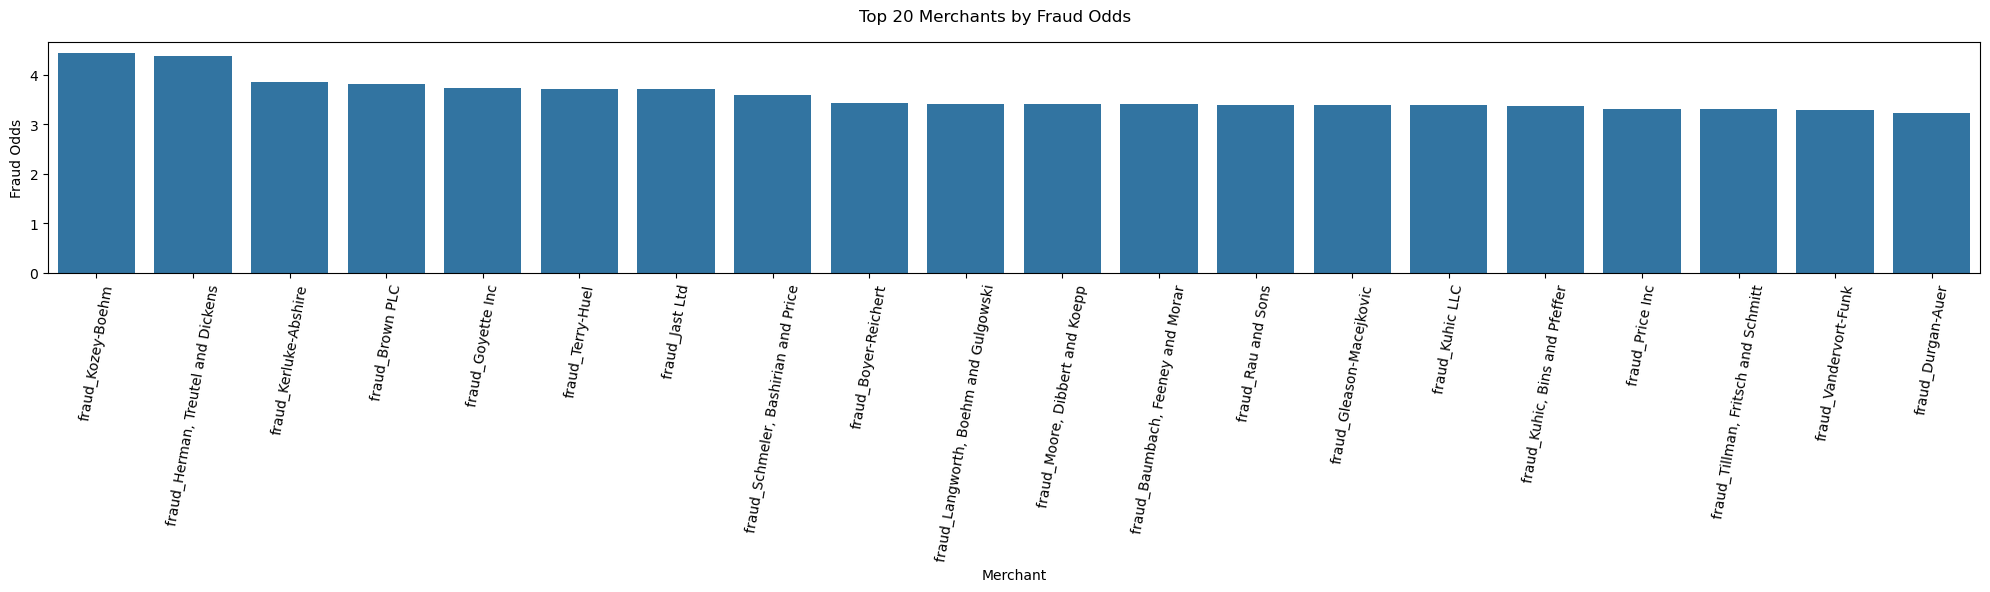

In [37]:
df_plot = df.groupby('merchant')['is_fraud'].mean().sort_values(ascending=False).to_frame('Fraud Odds')
df_plot = df_plot / df['is_fraud'].mean()
df_plot = df_plot.reset_index().rename(columns={"merchant": "Merchant"})

plt.figure(figsize=(20, 6))

ax = sns.barplot(
    data=df_plot.head(20),
    x="Merchant",
    y="Fraud Odds",
)

plt.xticks(rotation=80)
plt.suptitle("Top 20 Merchants by Fraud Odds")
plt.tight_layout()

In [38]:
(df_plot['Fraud Odds'] > 1).mean()

0.28715728715728717

In [39]:
df_plot = df.groupby(["merchant", "merchant_state"])["is_fraud"].agg(
    ['mean', 'count', 'sum']
).sort_values(
    by='mean',
    ascending=False
)

df_plot = df_plot[
    (df_plot['sum']>1) &
    (df_plot['mean']>df['is_fraud'].mean())
].reset_index()

df_plot['Fraud Odds'] = df_plot['mean'] / df['is_fraud'].mean()

In [40]:
df_plot.head(20)

,merchant,merchant_state,mean,count,sum,Fraud Odds
0,"fraud_Greenholt, O'Hara and Balistreri",DE,0.66667,3,2,115.16787
1,fraud_Kuphal-Bartoletti,ME,0.33333,6,2,57.58393
2,fraud_Durgan-Auer,MA,0.28571,7,2,49.35766
3,fraud_Klocko LLC,NV,0.28571,7,2,49.35766
4,fraud_Murray-Smitham,NV,0.28571,7,2,49.35766
5,fraud_Kerluke-Abshire,NV,0.27273,11,3,47.11413
6,fraud_Ruecker Group,VT,0.25000,8,2,43.18795
7,"fraud_Moore, Dibbert and Koepp",NH,0.21429,14,3,37.01824
8,"fraud_Kerluke, Kertzmann and Wiza",CT,0.20000,10,2,34.55036
9,fraud_Hudson-Ratke,NV,0.20000,10,2,34.55036


Text(0.5, 1.0, 'Transaction Proportions by Distance between Card and Merchant: Fraud vs Non-Fraud \n Percentages for Each Group')

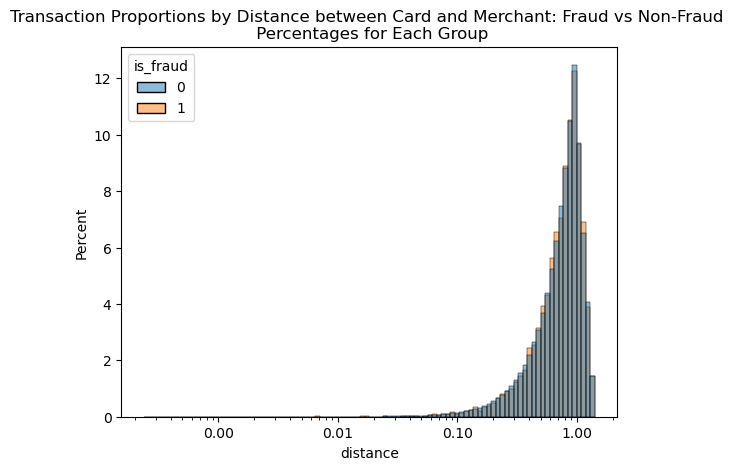

In [41]:
sns.histplot(
    data=df,
    x="distance",
    hue="is_fraud", 
    stat="percent",
    log_scale=(True, False),
    common_norm=False,
    fill=True,
    bins=100
)

plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=10.0))

plt.title('Transaction Proportions by Distance between Card and Merchant: Fraud vs Non-Fraud \n Percentages for Each Group')